In [1]:
# ! pip install seaborn pyarrow h2o

In [4]:
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
import pyspikelib.utils as spkutil
import pyspikelib.mpladeq as mpladeq

import os
import os.path as osp

from pathlib import Path

sns.set(font_scale=1.7, style='ticks')
mpladeq.beautify_mpl()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [6]:
np.random.seed(15)

In [9]:
datapath = Path('../data')

wake_data = spkutil.load_parquet(datapath / 'wake.parq')
sleep_data = spkutil.load_parquet(datapath / 'sleep.parq')

In [10]:
data = {}

data['wake_train'], data['wake_test'] = spkutil.split_by_spikes(wake_data, ratio=0.5)
data['sleep_train'], data['sleep_test'] = spkutil.split_by_spikes(sleep_data, ratio=0.5)

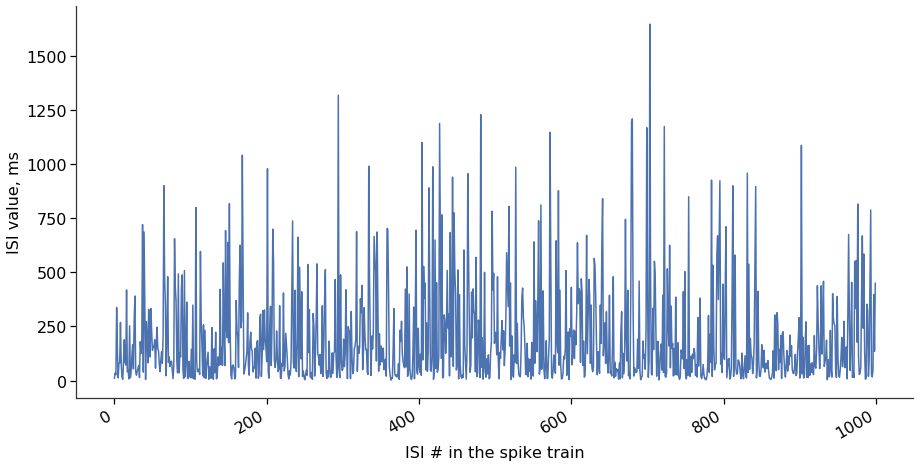

In [18]:
p.plot(data['wake_train']['series'][5][:1000])

p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

mpladeq.prettify(figsize = (15, 8))

In [19]:
window_size = 100
step_size = 100
total_samples = 5000

crop_data = {}
for key in data:
    crop_data[key] = spkutil.crop_isi_samples(data[key],
                                              window_size=window_size,
                                              step_size=step_size,
                                              total_samples=total_samples)

In [20]:
[(key, crop_data[key]['series'].shape) for key in crop_data]

[('wake_train', (5000, 100)),
 ('wake_test', (5000, 100)),
 ('sleep_train', (5000, 100)),
 ('sleep_test', (5000, 100))]

In [21]:
tsdata = {}
for key in data:
    tsdata[key] = spkutil.tsfresh_vectorize(crop_data[key]['series'],
                                            feature_dict='distribution_features',
                                            n_jobs=24)

Feature Extraction: 100%|██████████| 120/120 [00:05<00:00, 22.74it/s]


In [22]:
tsdata['wake_train'].head(10)

variable,value__abs_energy,value__count_above_mean,value__count_below_mean,value__kurtosis,value__large_standard_deviation__r_0.05,value__large_standard_deviation__r_0.1,value__large_standard_deviation__r_0.15000000000000002,value__large_standard_deviation__r_0.2,value__large_standard_deviation__r_0.25,value__large_standard_deviation__r_0.3,...,value__symmetry_looking__r_0.6000000000000001,value__symmetry_looking__r_0.6500000000000001,value__symmetry_looking__r_0.7000000000000001,value__symmetry_looking__r_0.7500000000000001,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9000000000000001,value__symmetry_looking__r_0.9500000000000001,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1.592561e+07,32.0,68.0,3.201378,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.420581e+04,1.0
1,1.576340e+06,33.0,67.0,10.552349,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.436813e+03,1.0
2,8.691874e+05,26.0,74.0,8.934928,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.949494e+03,1.0
3,7.683923e+04,37.0,63.0,4.490796,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.866556e+02,1.0
4,8.161123e+05,34.0,66.0,8.489534,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.077402e+03,1.0
5,2.282515e+06,31.0,69.0,5.481166,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.207716e+04,1.0
6,6.759591e+06,35.0,65.0,5.799821,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.515108e+04,1.0
7,2.723953e+08,30.0,70.0,23.265056,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.766395e+06,1.0
8,1.777322e+05,30.0,70.0,6.519467,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.993263e+02,1.0


In [23]:
samples = 4500
indices = np.random.choice(total_samples, samples)

X_train = pd.concat([tsdata['wake_train'].iloc[indices, :], tsdata['sleep_train'].iloc[indices, :]])
y_train = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

X_test = pd.concat([tsdata['wake_test'].iloc[indices, :], tsdata['sleep_test'].iloc[indices, :]])
y_test = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

In [26]:
X_train, scaler = spkutil.preprocess_tsfresh_features(X_train,
                                                      remove_low_variance=True)

X_test, _ = spkutil.preprocess_tsfresh_features(X_test,
                                                scaler=scaler,
                                                remove_low_variance=True)

X_train, X_test = spkutil.train_test_common_features(X_train, X_test)

In [2]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(nthreads=-1, max_mem_size=12)

In [30]:
X_y_train_h = h2o.H2OFrame(pd.concat([X_train.reset_index(drop=True), 
           pd.Series(y_train, name='target')], axis='columns'))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
X_y_train_h['target'] = X_y_train_h['target'].asfactor()

In [32]:
X_test_h = h2o.H2OFrame(X_test.reset_index(drop=True))

X_y_train_h.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:9000
Cols:37




,value__ratio_beyond_r_sigma__r_5,value__symmetry_looking__r_0.05,value__quantile__q_0.30000000000000004,value__quantile__q_0.8,value__symmetry_looking__r_0.15000000000000002,value__ratio_value_number_to_time_series_length,value__large_standard_deviation__r_0.15000000000000002,value__quantile__q_0.5,value__mean,value__minimum,value__ratio_beyond_r_sigma__r_2.5,value__symmetry_looking__r_0.1,value__quantile__q_0.2,value__count_below_mean,value__sum_values,value__standard_deviation,value__quantile__q_0.4,value__quantile__q_0.9,value__skewness,value__quantile__q_0.1,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_2,value__count_above_mean,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_6,value__abs_energy,value__quantile__q_0.7000000000000001,value__kurtosis,value__quantile__q_0.6,value__variance,value__large_standard_deviation__r_0.2,value__large_standard_deviation__r_0.25,value__median,value__maximum,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_1,target
type,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,enum
mins,-0.8930940065596837,-0.6205171643447935,-0.4248843992002089,-0.3868247134312038,-67.07458535093805,-5.1043078080447275,-1.8087222098135505,-0.360204430582338,-0.3852785132742642,-0.9598369592744994,-2.1031113497911695,-4.934785980775172,-0.513893815485444,-3.040149371436154,-0.38527851327426427,-0.3928085571197553,-0.4074424796941117,-0.36351914362461263,-1.874195022674808,-0.7136803553439405,-0.3172509408523428,-2.6491876191318746,-4.235633582107526,-2.999683492146109,-0.5309022428185854,-0.037637105871065654,-0.372318148002556,-1.0351947198026483,-0.3658825621080366,-0.03913244131706929,-0.5362402894866038,-0.09588997208210896,-0.360204430582338,-0.4004110699565529,-2.501021498051976,-2.708240998302468,
mean,1.9737298215558337e-16,-1.123604912815305e-14,7.579122514774402e-17,8.368614443396735e-17,1.0326554426380123e-15,-1.5631940186722203e-16,2.4253192047278086e-15,6.631732200427602e-17,-2.684272557315934e-17,2.5263741715914674e-17,5.431704468921654e-16,4.212728931128772e-15,1.768461920114027e-16,5.179067051762508e-16,-2.842170943040401e-17,-2.5855860662381424e-17,2.115838368707854e-16,1.164500594717942e-17,7.579122514774402e-17,3.410605131648481e-16,1.010549668636587e-15,-5.179067051762508e-15,-1.2252914732218617e-15,4.547473508864641e-16,-2.428477172442298e-15,3.157967714489334e-17,-2.5263741715914674e-17,-2.6053233644537006e-17,3.1579677144893343e-18,-7.105427357601002e-18,3.27165455221095e-15,6.173826881826648e-16,6.631732200427602e-17,-1.912050764632214e-18,7.705441223353975e-16,-2.153733981281726e-15,
maxs,4.344425145723432,1.6115589663918335,45.09443190265087,44.28985627020915,0.014908776472759013,1.1318654455224415,0.5528764973273136,47.14282472559823,47.12506764196572,13.386022414608348,3.7863856958968647,0.20264303333432349,42.72545616094641,4.2352465159254065,47.12506764196572,43.255367813689986,43.45170021766524,50.00721772666311,5.68927092198292,35.94713519272564,3.1520789105098617,3.7772398551105506,3.0406643312894786,3.405877392701103,4.195230482569395,64.97011348273406,46.199881364343454,7.2985914584289535,44.710298096654746,63.821817193475965,1.8648356335877565,10.428619158881135,47.14282472559823,39.124673560855285,3.710124606381741,6.273304836779457,
sigma,1.0000555601856569,1.0000555601855505,1.000055560185609,1.0000555601856158,1.0000555601856445,1.0000555601855787,1.0000555601855312,1.0000555601856167,1.0000555601856127,1.00005556018562,1.0000555601855872,1.0000555601855905,1.0000555601856156,1.0000555601856211,1.0000555601856127,1.0000555601856118,1.0000555601856096,1.000055560185617,1.0000555601856163,1.000055560185613,1.000055560185655,1.0000555601856465,1.0000555601856185,1.0000555601856647,1.0000555601856196,1.0000555601856076,1.0000555601856111,1.000055560185614,1.0000555601856118,1.0000555601856116,1.0000

In [40]:
aml = H2OAutoML(max_runtime_secs=1000,
                max_models=None,
                seed=42)

In [42]:
aml.train(x=list(X_train.columns.values),
          y='target',
          training_frame=X_y_train_h)

lb = aml.leaderboard
model_ids = list(lb['model_id'].as_data_frame().iloc[:, 0])
out_path = "."

for m_id in model_ids:
    mdl = h2o.get_model(m_id)
    h2o.save_model(model=mdl, path=out_path, force=True)

h2o.export_file(lb, osp.join(out_path, 'aml_leaderboard.h2o'), force=True)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Export File progress: |███████████████████████████████████████████████████| 100%


In [53]:
models_path = "./"

lb = h2o.import_file(path=os.path.join(models_path, "aml_leaderboard.h2o"))

lb.shape

Parse progress: |█████████████████████████████████████████████████████████| 100%


(86, 6)

In [69]:
lb = lb.as_data_frame()

In [71]:
lb.head()

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_AutoML_20191201_183834,0.970674,0.225228,0.086111,0.257315,0.066211
1,StackedEnsemble_BestOfFamily_AutoML_20191201_1...,0.970376,0.225475,0.088000,0.257579,0.066347
2,DRF_1_AutoML_20191201_183834,0.968544,0.254441,0.090556,0.270187,0.073001
3,DRF_1_AutoML_20191201_190018,0.968544,0.254441,0.090556,0.270187,0.073001
4,XRT_1_AutoML_20191201_190018,0.968467,0.250245,0.088667,0.269762,0.072771


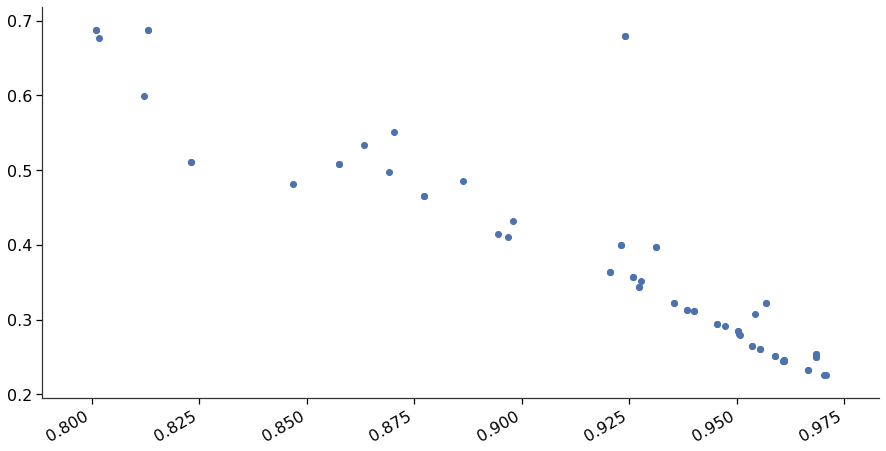

In [73]:
p.scatter(lb['auc'][lb['auc'] > 0.8], lb['logloss'][lb['auc'] > 0.8])

mpladeq.prettify(figsize = (15, 8))